# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 9

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter9()
# This is needed to render the plots in this chapter
from plots.chapter8 import *
from plots.chapter9 import *

In [2]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

from data_generation.square_sequences import generate_sequences
from stepbystep.v4 import StepByStep

In [3]:
%%writefile model_module/attn.py

class Attention(nn.Module):
    def __init__(self, hidden_dim, input_dim=None, proj_values=False):
        super().__init__()
        self.d_k = hidden_dim
        self.input_dim = hidden_dim if input_dim is None else input_dim
        self.proj_values = proj_values
        # Affine transformations for Q, K, and V
        self.linear_query = nn.Linear(self.input_dim, hidden_dim)
        self.linear_key = nn.Linear(self.input_dim, hidden_dim)
        self.linear_value = nn.Linear(self.input_dim, hidden_dim)
        self.alphas = None
                
    def init_keys(self, keys):
        """ 为解码器接收来自编码器的隐藏状态序列 """
        self.keys = keys
        self.proj_keys = self.linear_key(self.keys)
        self.values = self.linear_value(self.keys) \
                      if self.proj_values else self.keys
                
    def score_function(self, query):
        """ 计算对齐向量/注意力分数 """
        proj_query = self.linear_query(query)
        # scaled dot product
        # N, 1, H x N, H, L -> N, 1, L
        dot_products = torch.bmm(proj_query, self.proj_keys.permute(0, 2, 1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores
            
    def forward(self, query, mask=None):
        # Query is batch-first N, 1, H
        scores = self.score_function(query) # N, 1, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, 1, L
        self.alphas = alphas.detach()
        
        # N, 1, L x N, L, H -> N, 1, H
        context = torch.bmm(alphas, self.values)
        return context

Overwriting model_module/attn.py


In [4]:
%run -i model_module/attn.py

In [5]:
%%writefile model_module/mha.py

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, input_dim=None, proj_values=True):
        super().__init__()
        self.linear_out = nn.Linear(n_heads * d_model, d_model)
        self.attn_heads = nn.ModuleList(
            [
                Attention(
                    d_model, # it means hidden_dim in Attention Class
                    input_dim=input_dim, 
                    proj_values=proj_values
                ) 
                for _ in range(n_heads)
            ]
        )
        
    def init_keys(self, key):
        for attn in self.attn_heads:
            attn.init_keys(key)
        
    @property
    def alphas(self):
        # Shape: n_heads, N, 1, L (source)
        return torch.stack([attn.alphas for attn in self.attn_heads], dim=0)
        
    def output_function(self, contexts):
        # N, 1, n_heads * D
        concatenated = torch.cat(contexts, axis=-1)
        # Linear transf. to go back to original dimension
        out = self.linear_out(concatenated) # N, 1, D
        return out
        
    def forward(self, query, mask=None):
        contexts = [attn(query, mask=mask) for attn in self.attn_heads]
        out = self.output_function(contexts)
        return out

Overwriting model_module/mha.py


In [6]:
%run -i model_module/mha.py

# Part II

## 2.0 Data Preparation

In [27]:
points, directions = generate_sequences(n=256, seed=13)
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]

test_points, test_directions = generate_sequences(seed=19)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]

train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)

generator = torch.Generator()  # TODO: 需要详细了解
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

## 2.1 Self-Attention

### 2.1.1 Encoder

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encoder_self.png?raw=1)

$$
\Large
\alpha_{\color{blue}{0}\color{red}0}, \alpha_{{\color{blue}{0}\color{red}1}} = \text{softmax}(\frac{\color{red}{Q_0}\color{black}\cdot K_0}{\sqrt{2}}, \frac{\color{red}{Q_0}\color{black}\cdot K_1}{\sqrt{2}})
\\
\Large
\color{blue}{\text{context vector}_0}\color{black}= \alpha_{\color{blue}{0}\color{red}0}V_0 + \alpha_{{\color{blue}{0}\color{red}1}}V_1
$$

$$
\Large
\alpha_{\color{blue}{1}\color{red}0}, \alpha_{{\color{blue}{1}\color{red}1}} = \text{softmax}(\frac{\color{red}{Q_1}\color{black}\cdot K_0}{\sqrt{2}}, \frac{\color{red}{Q_1}\color{black}\cdot K_1}{\sqrt{2}})
\\
\Large
\color{blue}{\text{context vector}_1}\color{black}= \alpha_{\color{blue}{1}\color{red}0}V_0 + \alpha_{{\color{blue}{1}\color{red}1}}V_1
$$

$$
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_0} & \color{red}{x_1} \\
\hline
 \color{blue}{h_0} & \alpha_{\color{blue}{0}\color{red}0} & \alpha_{{\color{blue}{0}\color{red}1}} \\
 \color{blue}{h_1} & \alpha_{\color{blue}{1}\color{red}0} & \alpha_{{\color{blue}{1}\color{red}1}}
\end{array}
$$

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/transf_encself.png?raw=1)

In [7]:
class EncoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=n_features)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, d_model),
        )
         
    def forward(self, query, mask=None):
        self.self_attn_heads.init_keys(query)
        att = self.self_attn_heads(query, mask)
        out = self.ffn(att)
        return out

In [8]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]

In [9]:
torch.manual_seed(11)
encself = EncoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
query = source_seq
encoder_states = encself(query)
encoder_states

tensor([[[-0.0498,  0.2193],
         [-0.0642,  0.2258]]], grad_fn=<ViewBackward0>)

跟踪张量在编码器内部的形状变化（可以将该变化过程称为**Shape Flow**）：

In [10]:
print(encself)

EncoderSelfAttn(
  (self_attn_heads): MultiHeadAttention(
    (linear_out): Linear(in_features=6, out_features=2, bias=True)
    (attn_heads): ModuleList(
      (0-2): 3 x Attention(
        (linear_query): Linear(in_features=2, out_features=2, bias=True)
        (linear_key): Linear(in_features=2, out_features=2, bias=True)
        (linear_value): Linear(in_features=2, out_features=2, bias=True)
      )
    )
  )
  (ffn): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [11]:
print(f"shape of encoder's inputs: {query.shape}")  # N, L, F
print(f"shape of encoder's outputs: {encoder_states.shape}")  # N, L, H

# (N, L, F) -> (N, L, 3 * H) -> (N, L, H)
# (1, 2, 2) -> (1, 2, 6) -> (1, 2, 2)
attn_scores = encself.self_attn_heads(query)
print(f"shape of attn_scores': {attn_scores.shape}")

# (1, 2, 2) -> (1, 2, 10) -> (1, 2, 2)
ffn_outs = encself.ffn(attn_scores)
print(f"shape of ffn's outputs: {ffn_outs.shape}")

shape of encoder's inputs: torch.Size([1, 2, 2])
shape of encoder's outputs: torch.Size([1, 2, 2])
shape of attn_scores': torch.Size([1, 2, 2])
shape of ffn's outputs: torch.Size([1, 2, 2])


### 2.1.2 Cross-Attention

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/cross_attn.png?raw=1)

### 2.1.3 Decoder

解码器比编码器多了个交叉注意力模块：

In [12]:
class DecoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = d_model if n_features is None else n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=self.n_features)
        # 接收来自编码器的隐藏状态作为K和V的交叉注意力层
        self.cross_attn_heads = MultiHeadAttention(n_heads, d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, self.n_features),
        )
        
    def init_keys(self, states):
        # 接收来自编码器的隐藏状态作为K和V
        self.cross_attn_heads.init_keys(states)
         
    def forward(self, query, source_mask=None, target_mask=None):
        self.self_attn_heads.init_keys(query)
        att1 = self.self_attn_heads(query, target_mask)
        att2 = self.cross_attn_heads(att1, source_mask)
        out = self.ffn(att2)
        return out

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/decoder_self.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/transf_decself.png?raw=1)

#### Subsequent Inputs and Teacher Forcing

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/shifted_target.png?raw=1)

In [13]:
shifted_seq = torch.cat([source_seq[:, -1:], target_seq[:, :-1]], dim=1)
print(f"source_seq: \n{source_seq}")
print(f"target_seq: \n{target_seq}")
print(f"shifted_seq: \n{shifted_seq}")

source_seq: 
tensor([[[-1., -1.],
         [-1.,  1.]]])
target_seq: 
tensor([[[ 1.,  1.],
         [ 1., -1.]]])
shifted_seq: 
tensor([[[-1.,  1.],
         [ 1.,  1.]]])


#### Attention Scores

$$
\Large
\alpha_{\color{green}{2}\color{red}1}, \alpha_{{\color{green}{2}\color{red}2}} = \text{softmax}(\frac{\color{red}{Q_1}\color{black}\cdot K_1}{\sqrt{2}}, \frac{\color{red}{Q_1}\color{black}\cdot K_2}{\sqrt{2}})
\\
\Large
\color{green}{\text{context vector}_2}\color{black}= \alpha_{\color{green}{2}\color{red}1}V_1 + \alpha_{{\color{green}{2}\color{red}2}}V_2
$$

$$
\Large
\alpha_{\color{green}{3}\color{red}1}, \alpha_{{\color{green}{3}\color{red}2}} = \text{softmax}(\frac{\color{red}{Q_2}\color{black}\cdot K_1}{\sqrt{2}}, \frac{\color{red}{Q_2}\color{black}\cdot K_2}{\sqrt{2}})
\\
\Large
\color{green}{\text{context vector}_3}\color{black}= \alpha_{\color{green}{3}\color{red}1}V_1 + \alpha_{{\color{green}{3}\color{red}2}}V_2
$$

$$
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_1} & \color{red}{x_2} \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1} & \alpha_{{\color{green}{2}\color{red}2}} \\
 \color{green}{h_3} & \alpha_{\color{green}{3}\color{red}1} & \alpha_{{\color{green}{3}\color{red}2}}
\end{array}
$$

#### Target Mask (Training)

$$
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_1} & \color{red}{x_2} \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1} & 0 \\
 \color{green}{h_3} & \alpha_{\color{green}{3}\color{red}1} & \alpha_{{\color{green}{3}\color{red}2}}
\end{array}
$$

In [14]:
triu1 = torch.triu(torch.ones(4, 4), diagonal=1)
print(f"triu1: \n{triu1}")

triu1.bool()

triu1: 
tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]])


tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True],
        [False, False, False, False]])

In [15]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1)).bool()
    return subsequent_mask

In [16]:
subsequent_mask(2) # 1, L, L

tensor([[[ True, False],
         [ True,  True]]])

In [17]:
torch.manual_seed(13)
decself = DecoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
decself.init_keys(encoder_states)

query = shifted_seq
out = decself(query, target_mask=subsequent_mask(2))

print(f"{decself.self_attn_heads.alphas.shape}\n")
decself.self_attn_heads.alphas

torch.Size([3, 1, 2, 2])



tensor([[[[1.0000, 0.0000],
          [0.4011, 0.5989]]],


        [[[1.0000, 0.0000],
          [0.4264, 0.5736]]],


        [[[1.0000, 0.0000],
          [0.6304, 0.3696]]]])

#### Target Mask (Evaluation/Prediction)

$$
\Large
1^{\text{st}}\ \text{Step}
\Large
\begin{cases}
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_1} & \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1}
\end{array}
\end{cases}
$$

In [18]:
inputs = source_seq[:, -1:]
trg_masks = subsequent_mask(1)
out = decself(inputs, target_mask=trg_masks)
out

tensor([[[0.4132, 0.3728]]], grad_fn=<ViewBackward0>)

In [19]:
inputs = torch.cat([inputs, out[:, -1:, :]], dim=-2)
inputs

tensor([[[-1.0000,  1.0000],
         [ 0.4132,  0.3728]]], grad_fn=<CatBackward0>)

$$
\Large
2^{\text{nd}}\ \text{Step}
\Large
\begin{cases}
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_1} & \color{green}{x_2} \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1} & 0 \\
 \color{green}{h_3} & \alpha_{\color{green}{3}\color{red}1} & \alpha_{{\color{green}{3}\color{green}2}}
\end{array}
\end{cases}
$$

In [20]:
trg_masks = subsequent_mask(2)
out = decself(inputs, target_mask=trg_masks)
out

tensor([[[0.4132, 0.3728],
         [0.4132, 0.3728]]], grad_fn=<ViewBackward0>)

In [21]:
inputs = torch.cat([inputs, out[:, -1:, :]], dim=-2)
inputs

tensor([[[-1.0000,  1.0000],
         [ 0.4132,  0.3728],
         [ 0.4132,  0.3728]]], grad_fn=<CatBackward0>)

In [22]:
inputs[:, 1:]

tensor([[[0.4132, 0.3728],
         [0.4132, 0.3728]]], grad_fn=<SliceBackward0>)

### 2.1.4 Encoder + Decoder + Self-Attention

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encdec_self_simplified.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/transf_encdecself.png?raw=1)

In [23]:
class EncoderDecoderSelfAttn(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)
        
    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask
                
    def encode(self, source_seq, source_mask):
        # Encodes the source sequence and uses the result
        # to initialize the decoder
        encoder_states = self.encoder(source_seq, source_mask)
        self.decoder.init_keys(encoder_states)
        
    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Decodes/generates a sequence using the shifted (masked)
        # target sequence - used in TRAIN mode
        outputs = self.decoder(shifted_target_seq, 
                               source_mask=source_mask,
                               target_mask=target_mask)
        return outputs
    
    def predict(self, source_seq, source_mask):
        # Decodes/generates a sequence using one input
        # at a time - used in EVAL mode
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs
                
    def forward(self, X, source_mask=None):
        # Sends the mask to the same device as the inputs
        self.trg_masks = self.trg_masks.type_as(X).bool()
        # Slices the input to get source sequence
        source_seq = X[:, :self.input_len, :]
        # Encodes source sequence AND initializes decoder
        self.encode(source_seq, source_mask)
        if self.training:
            # Slices the input to get the shifted target seq
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            # Decodes using the mask to prevent cheating
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            # Decodes using its own predictions
            outputs = self.predict(source_seq, source_mask)
            
        return outputs

### 2.1.5 Model Configuration & Training

In [24]:
torch.manual_seed(23)
encself = EncoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
decself = DecoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
model = EncoderDecoderSelfAttn(encself, decself, input_len=2, target_len=2)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [28]:
sbs_seq_selfattn = StepByStep(model, loss, optimizer)
sbs_seq_selfattn.set_loaders(train_loader, test_loader)
sbs_seq_selfattn.train(100)

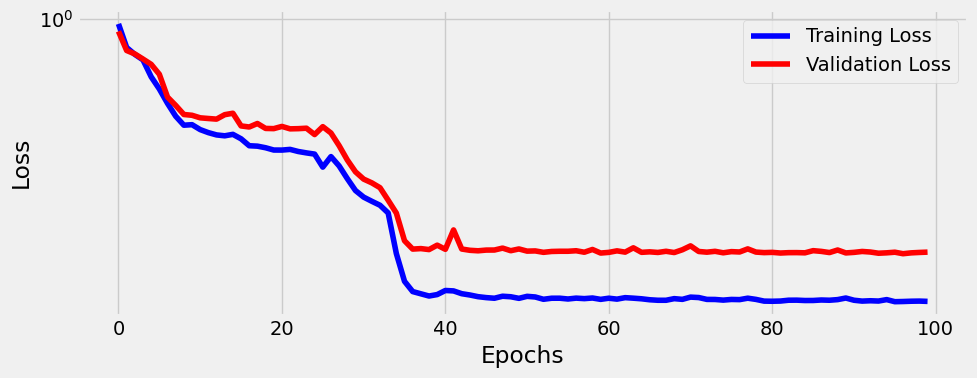

In [29]:
fig = sbs_seq_selfattn.plot_losses()

### 2.1.6 Visualizing Predictions

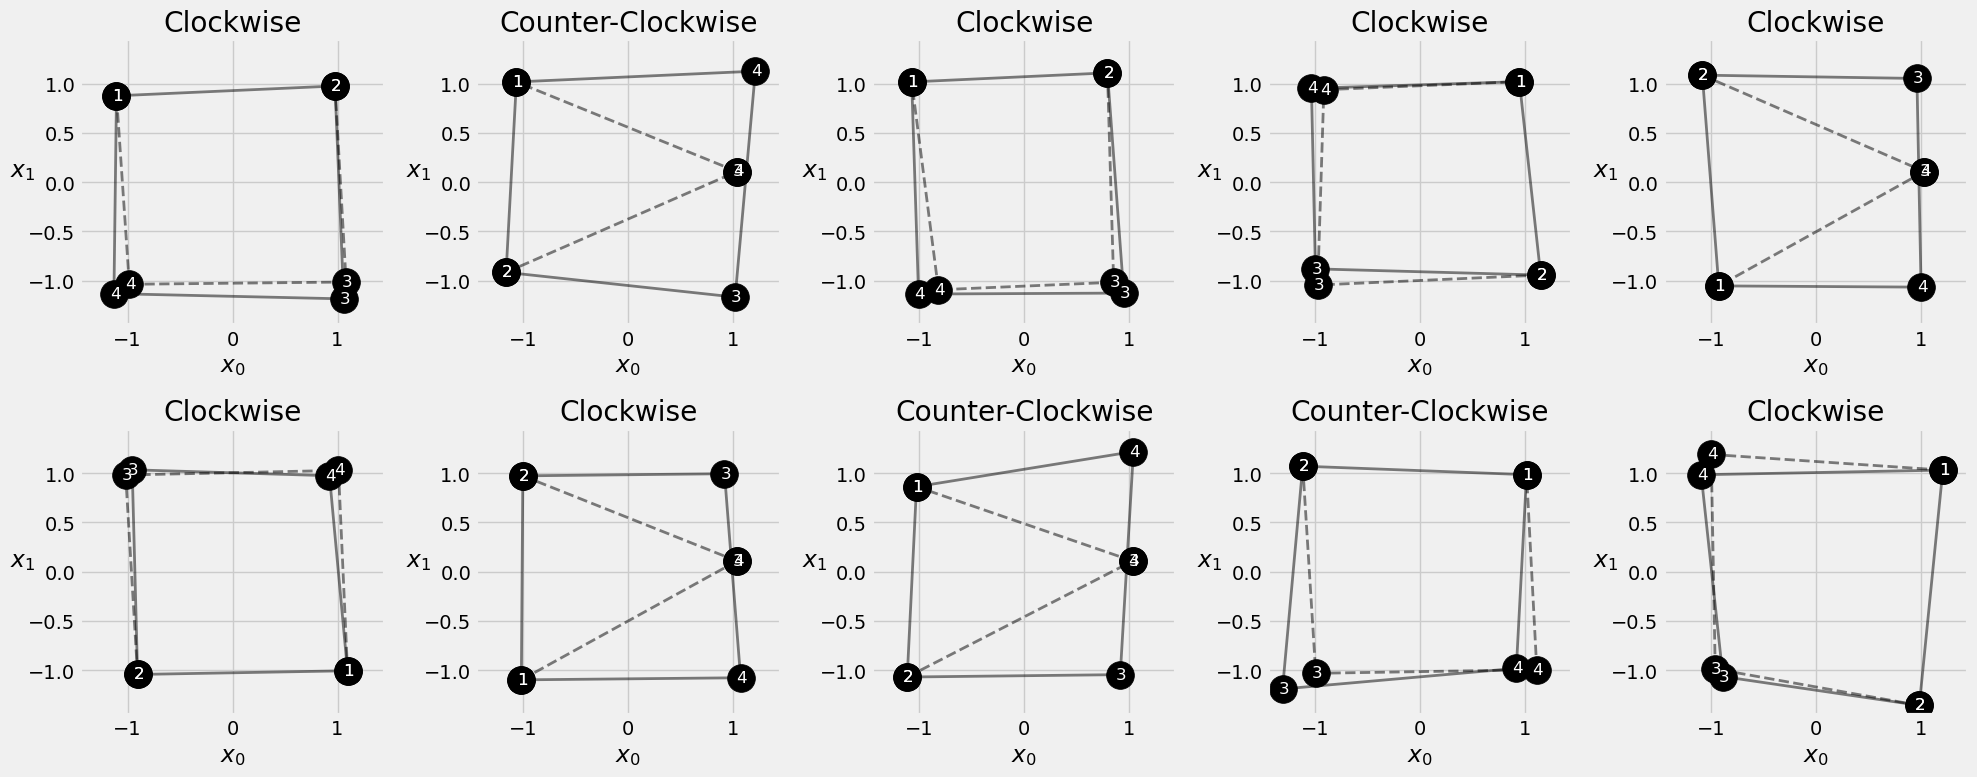

In [30]:
fig = sequence_pred(sbs_seq_selfattn, full_test, test_directions)

### 2.1.7 Sequential No More

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encoder_lost_seq.png?raw=1)

## 2.2 Positional Encoding (PE)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_norm4.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_norm4_long.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_mod4mod8.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_modnorm4.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_modnorm_mult.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encoded_distances.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_modnorm_deg.png?raw=1)

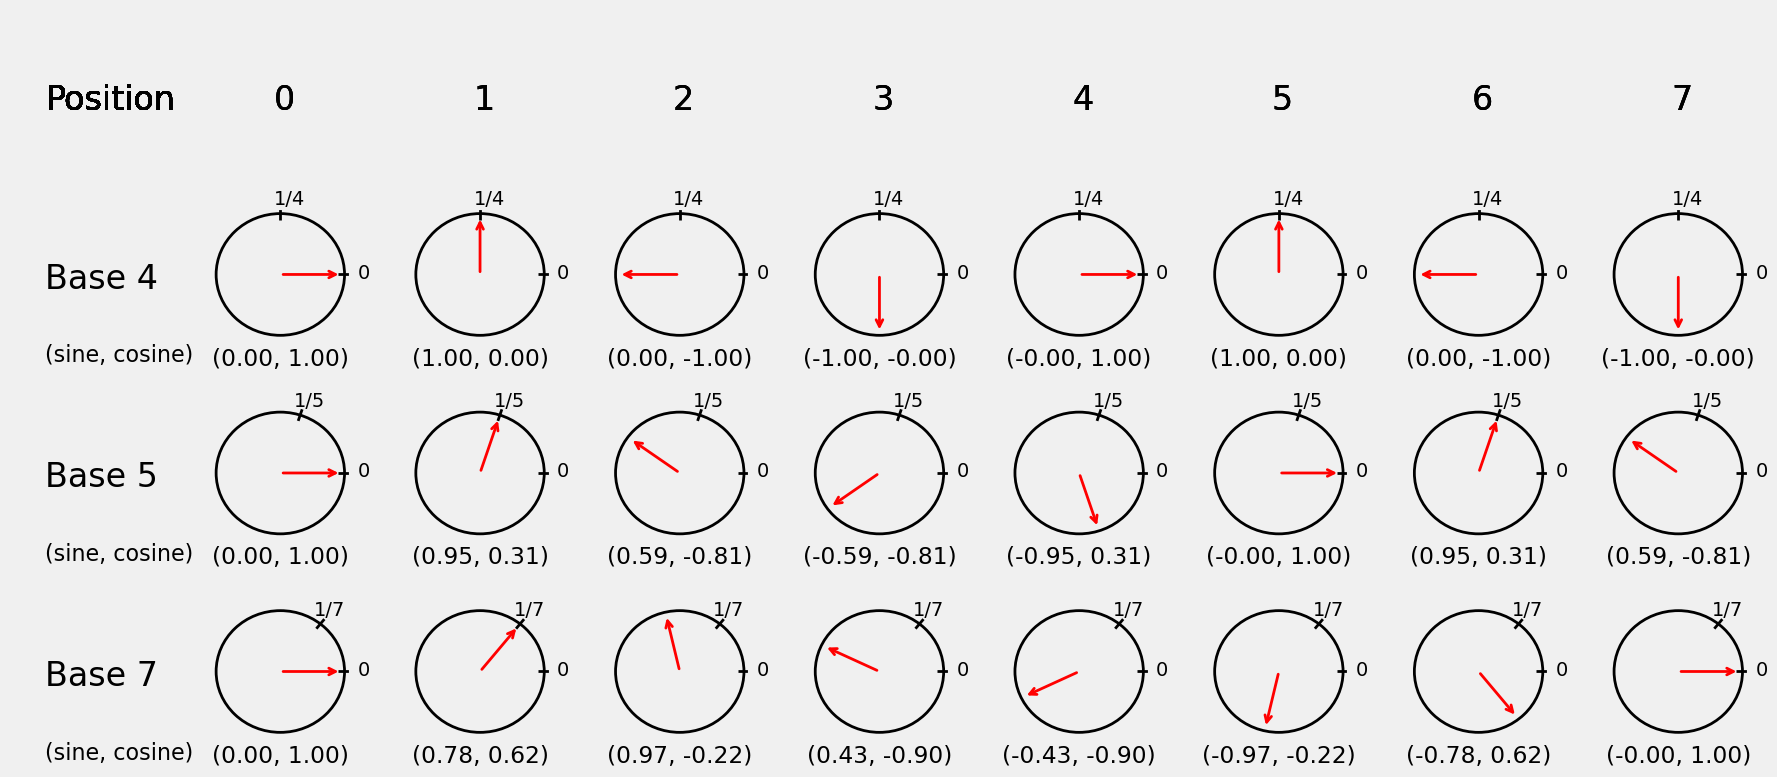

In [31]:
fig = encoding_degrees(dims=3, seqs=(4, 5, 7), tot=8)

上图揭示的现象类似时钟上的时针、分针以及秒针。

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_modnorm_sincos.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/sincos_distance.png?raw=1)

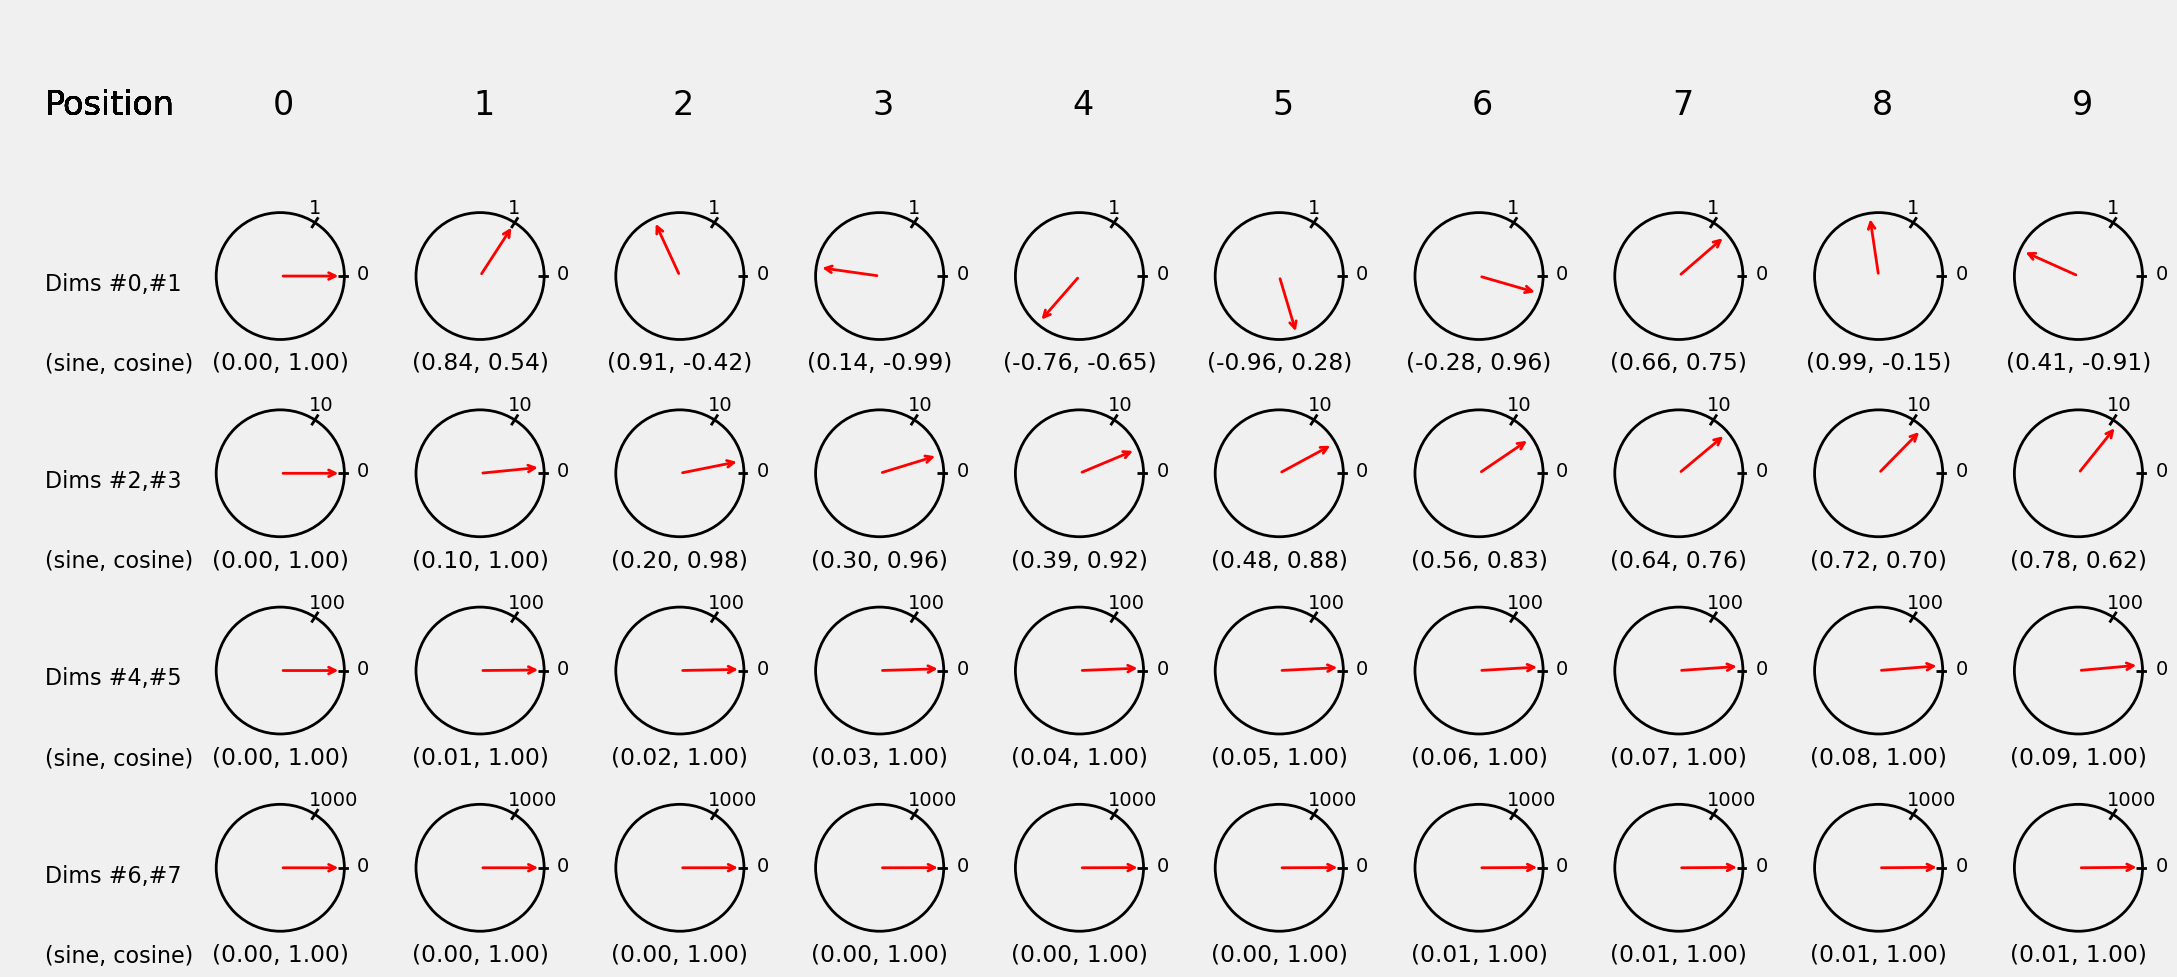

In [32]:
fig = exponential_dials(d_model=8, max_len=10)

$$
\Large
\left(\frac{1}{10000^{\frac{0}{8}}}, \frac{1}{10000^{\frac{2}{8}}}, \frac{1}{10000^{\frac{4}{8}}}, \frac{1}{10000^{\frac{6}{8}}}\right)=(1, 0.1, 0.01, 0.001)
$$

$$
\Large
\text{PE}_{\text{pos},\ 2d} = \text{sin} \left(\frac{1}{10000^{\frac{2d}{d_{\text{model}}}}}\text{pos}\right); \text{PE}_{\text{pos},\ 2d+1} = \text{cos} \left(\frac{1}{10000^{\frac{2d}{d_{\text{model}}}}}\text{pos}\right)
$$

In [33]:
max_len = 10
d_model = 8

position = torch.arange(0, max_len).float().unsqueeze(1)
angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

encoding = torch.zeros(max_len, d_model)
encoding[:, 0::2] = torch.sin(angular_speed * position)
encoding[:, 1::2] = torch.cos(angular_speed * position)

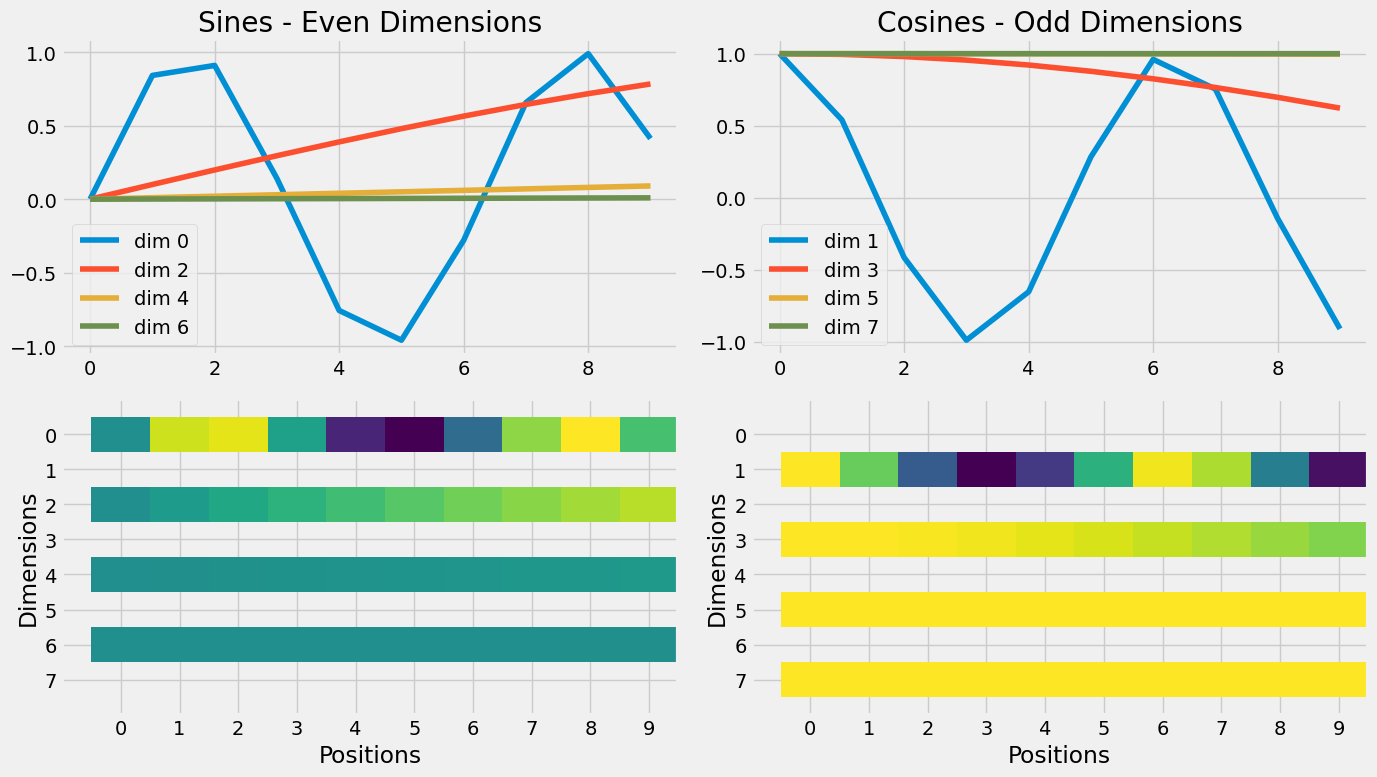

In [34]:
fig = encoding_heatmap(d_model=8, max_len=10)

In [35]:
np.round(encoding[0:4], 4) # first four positions

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0998,  0.9950,  0.0100,  1.0000,  0.0010,  1.0000],
        [ 0.9093, -0.4161,  0.1987,  0.9801,  0.0200,  0.9998,  0.0020,  1.0000],
        [ 0.1411, -0.9900,  0.2955,  0.9553,  0.0300,  0.9996,  0.0030,  1.0000]])

### 2.2.1 A Note on Encoded Distances

In [36]:
distances = np.zeros((5, 5))
for i, v1 in enumerate(encoding[:5]):
    for j, v2 in enumerate(encoding[:5]):
        distances[i, j] = np.linalg.norm(v1 - v2)

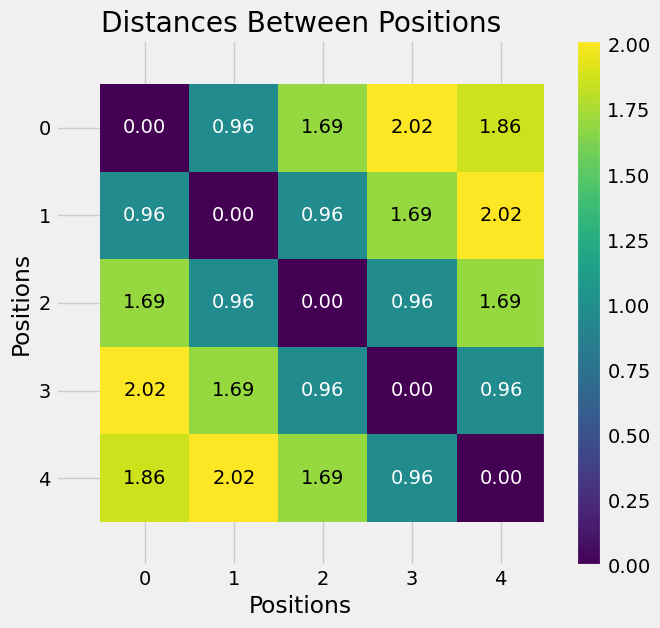

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6.5))
ax.set_title('Distances Between Positions')
fig = plot_mesh(distances, ax, showvals=True, colorbar=True, ylabel='Positions')

In [38]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * angular_speed) # even dimensions
        pe[:, 1::2] = torch.cos(position * angular_speed) # odd dimensions
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x is N, L, D
        # pe is 1, maxlen, D
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

In [39]:
posenc = PositionalEncoding(2, 2)

In [40]:
list(posenc.parameters()), posenc.state_dict()

([],
 OrderedDict([('pe', tensor([[[0.0000, 1.0000],
                        [0.8415, 0.5403]]]))]))

In [41]:
posenc.pe

tensor([[[0.0000, 1.0000],
         [0.8415, 0.5403]]])

In [42]:
source_seq # 1, L, D

tensor([[[-1., -1.],
         [-1.,  1.]]])

In [43]:
source_seq + posenc.pe

tensor([[[-1.0000,  0.0000],
         [-0.1585,  1.5403]]])

$$
\text{standardized}\ x = \frac{\text{"raw"}\ x}{\sqrt{d_x}} \implies \text{"raw"} x = \sqrt{d_x}\ \text{standardized}\ x
$$

In [44]:
posenc(source_seq)

tensor([[[-1.4142, -0.4142],
         [-0.5727,  1.9545]]])

### 2.2.2 Encoder + Decoder + PE

In [45]:
class EncoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = EncoderSelfAttn(n_heads, d_model, ff_units, n_features)
    
    def forward(self, query, mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, mask)
        return out
    
class DecoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = DecoderSelfAttn(n_heads, d_model, ff_units, n_features)
        
    def init_keys(self, states):
        self.layer.init_keys(states)
    
    def forward(self, query, source_mask=None, target_mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, source_mask, target_mask)
        return out

### 2.2.3 Model Configuration & Training

In [46]:
torch.manual_seed(43)
encpe = EncoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)
decpe = DecoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)

model = EncoderDecoderSelfAttn(encpe, decpe, input_len=2, target_len=2)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [47]:
sbs_seq_selfattnpe = StepByStep(model, loss, optimizer)
sbs_seq_selfattnpe.set_loaders(train_loader, test_loader)
sbs_seq_selfattnpe.train(100)

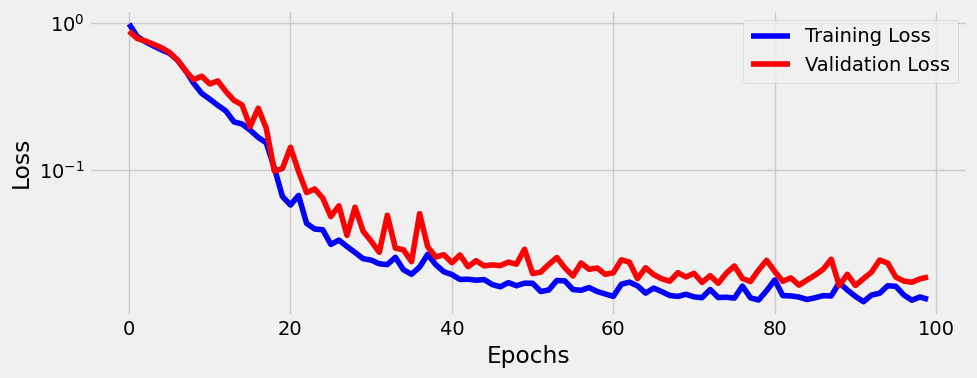

In [48]:
fig = sbs_seq_selfattnpe.plot_losses()

### 2.2.4 Visualizing Predictions

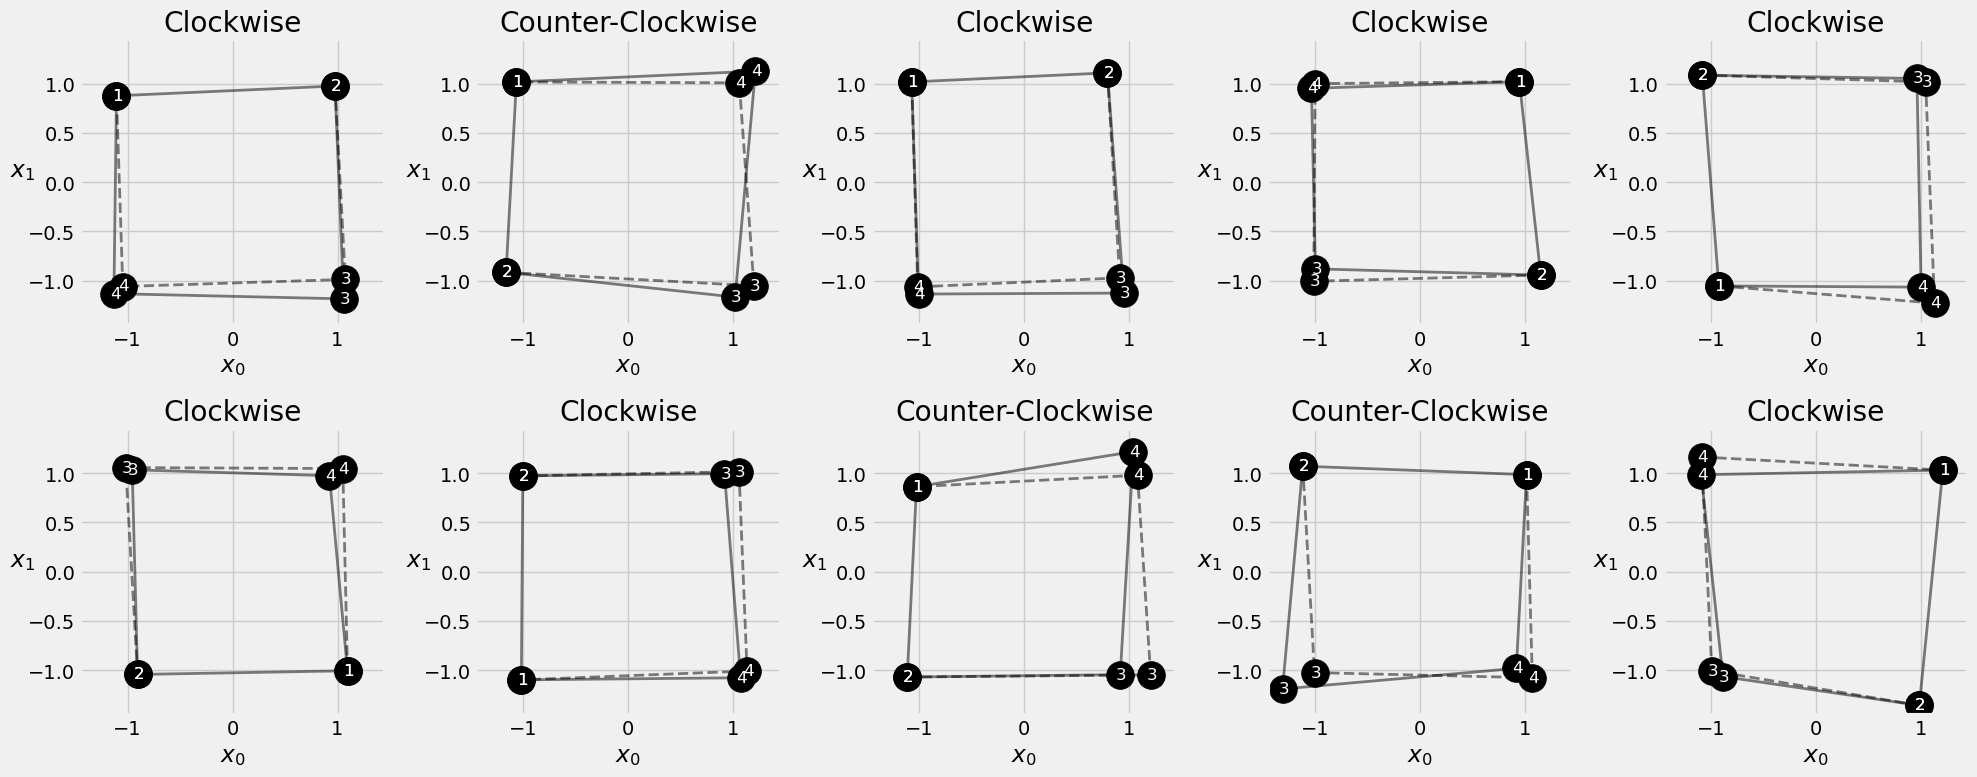

In [49]:
fig = sequence_pred(sbs_seq_selfattnpe, full_test, test_directions)

### 2.2.5 Visualizing Attention

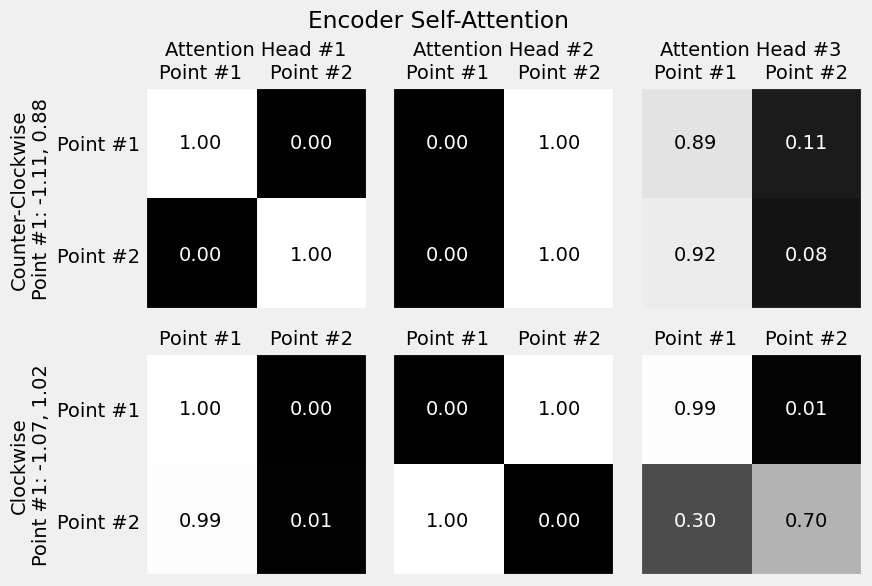

In [50]:
inputs = full_test[:2, :2]
source_labels = ['Point #1', 'Point #2']
target_labels = ['Point #3', 'Point #4']
point_labels = [f'{"Counter-" if not directions[i] else ""}Clockwise\nPoint #1: {inp[0, 0]:.2f}, {inp[0, 1]:.2f}' for i, inp in enumerate(inputs)]

fig = plot_attention(model, inputs, point_labels, source_labels, target_labels, decoder=False, self_attn=True, alphas_attr='encoder.layer.self_attn_heads.alphas')
fig.suptitle('Encoder Self-Attention')
fig.subplots_adjust(top=0.85) 

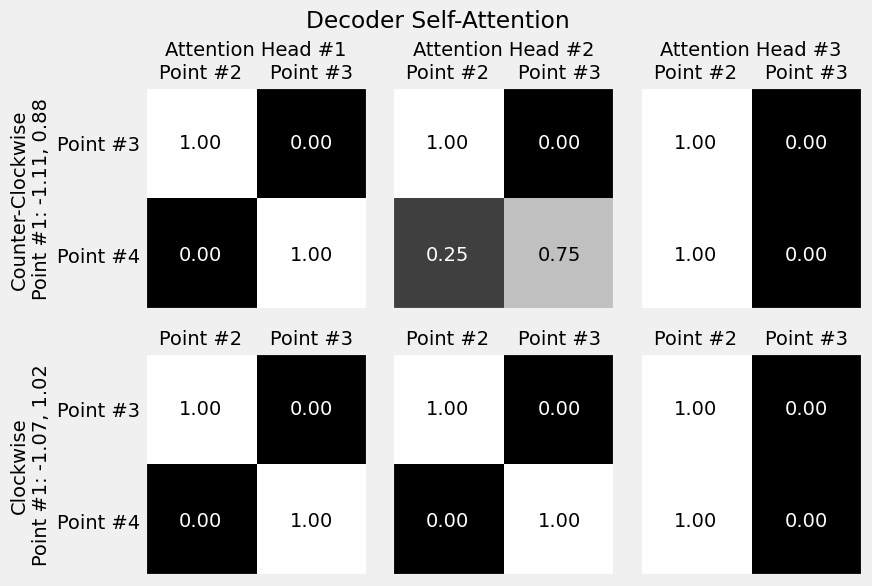

In [51]:
fig = plot_attention(model, inputs, point_labels, source_labels, target_labels, 
                     decoder=True, self_attn=True, alphas_attr='decoder.layer.self_attn_heads.alphas')
fig.suptitle('Decoder Self-Attention')
fig.subplots_adjust(top=0.85) 

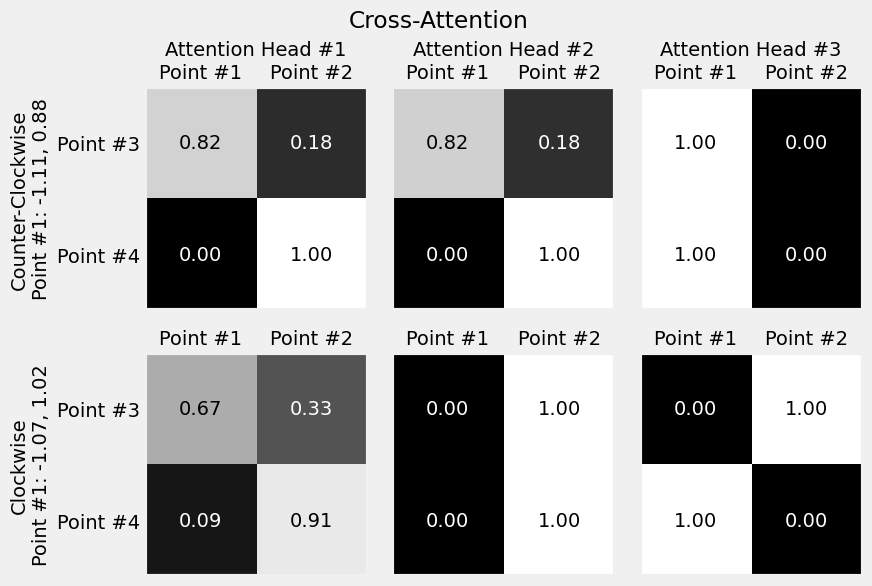

In [52]:
fig = plot_attention(model, inputs, point_labels, source_labels, target_labels, self_attn=False, alphas_attr='decoder.layer.cross_attn_heads.alphas')
fig.suptitle('Cross-Attention')
fig.subplots_adjust(top=0.85) 

## 2.3 Putting It All Together

### 2.3.1 Data Preparation

In [53]:
# Training set
points, directions = generate_sequences(n=256, seed=13)
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]
train_data = TensorDataset(full_train, target_train)

generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)

# Validation/Test Set
test_points, test_directions = generate_sequences(seed=19)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]
test_data = TensorDataset(source_test, target_test)
test_loader = DataLoader(test_data, batch_size=16)

### 2.3.2 Model Assembly

In [54]:
class EncoderDecoderSelfAttn(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)
        
    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask
                
    def encode(self, source_seq, source_mask):
        # Encodes the source sequence and uses the result
        # to initialize the decoder
        encoder_states = self.encoder(source_seq, source_mask)
        self.decoder.init_keys(encoder_states)
        
    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Decodes/generates a sequence using the shifted (masked)
        # target sequence - used in TRAIN mode
        outputs = self.decoder(shifted_target_seq, 
                               source_mask=source_mask,
                               target_mask=target_mask)
        return outputs
    
    def predict(self, source_seq, source_mask):
        # Decodes/generates a sequence using one input
        # at a time - used in EVAL mode
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs
                
    def forward(self, X, source_mask=None):
        # Sends the mask to the same device as the inputs
        self.trg_masks = self.trg_masks.type_as(X).bool()
        # Slices the input to get source sequence
        source_seq = X[:, :self.input_len, :]
        # Encodes source sequence AND initializes decoder
        self.encode(source_seq, source_mask)
        if self.training:
            # Slices the input to get the shifted target seq
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            # Decodes using the mask to prevent cheating
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            # Decodes using its own predictions
            outputs = self.predict(source_seq, source_mask)
            
        return outputs

### 2.3.3 Encoder + Decoder + Positional Encoding

In [55]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * angular_speed) # even dimensions
        pe[:, 1::2] = torch.cos(position * angular_speed) # odd dimensions
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x is N, L, D
        # pe is 1, maxlen, D
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

class EncoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = EncoderSelfAttn(n_heads, d_model, ff_units, n_features)
    
    def forward(self, query, mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, mask)
        return out
    
class DecoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = DecoderSelfAttn(n_heads, d_model, ff_units, n_features)
        
    def init_keys(self, states):
        self.layer.init_keys(states)
    
    def forward(self, query, source_mask=None, target_mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, source_mask, target_mask)
        return out

### 2.3.4 Self-Attention "Layers"

In [56]:
class EncoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=n_features)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, d_model),
        )
         
    def forward(self, query, mask=None):
        self.self_attn_heads.init_keys(query)
        att = self.self_attn_heads(query, mask)
        out = self.ffn(att)
        return out

class DecoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = d_model if n_features is None else n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=self.n_features)
        self.cross_attn_heads = MultiHeadAttention(n_heads, d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, self.n_features),
        )
        
    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)
         
    def forward(self, query, source_mask=None, target_mask=None):
        self.self_attn_heads.init_keys(query)
        att1 = self.self_attn_heads(query, target_mask)
        att2 = self.cross_attn_heads(att1, source_mask)
        out = self.ffn(att2)
        return out

### 2.3.5 Attention Heads

In [57]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, input_dim=None, proj_values=True):
        super().__init__()
        self.linear_out = nn.Linear(n_heads * d_model, d_model)
        self.attn_heads = nn.ModuleList([Attention(d_model, 
                                                   input_dim=input_dim, 
                                                   proj_values=proj_values) 
                                         for _ in range(n_heads)])
        
    def init_keys(self, key):
        for attn in self.attn_heads:
            attn.init_keys(key)
        
    @property
    def alphas(self):
        # Shape: n_heads, N, 1, L (source)
        return torch.stack([attn.alphas for attn in self.attn_heads], dim=0)
        
    def output_function(self, contexts):
        # N, 1, n_heads * D
        concatenated = torch.cat(contexts, axis=-1)
        out = self.linear_out(concatenated) # N, 1, D
        return out
        
    def forward(self, query, mask=None):
        contexts = [attn(query, mask=mask) for attn in self.attn_heads]
        out = self.output_function(contexts)
        return out
    
class Attention(nn.Module):
    def __init__(self, hidden_dim, input_dim=None, proj_values=False):
        super().__init__()
        self.d_k = hidden_dim
        self.input_dim = hidden_dim if input_dim is None else input_dim
        self.proj_values = proj_values
        self.linear_query = nn.Linear(self.input_dim, hidden_dim)
        self.linear_key = nn.Linear(self.input_dim, hidden_dim)
        self.linear_value = nn.Linear(self.input_dim, hidden_dim)
        self.alphas = None
                
    def init_keys(self, keys):
        self.keys = keys
        self.proj_keys = self.linear_key(self.keys)
        self.values = self.linear_value(self.keys) \
                      if self.proj_values else self.keys
                
    def score_function(self, query):
        proj_query = self.linear_query(query)
        # scaled dot product
        # N, 1, H x N, H, L -> N, 1, L
        dot_products = torch.bmm(proj_query, self.proj_keys.permute(0, 2, 1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores
            
    def forward(self, query, mask=None):
        # Query is batch-first N, 1, H
        scores = self.score_function(query) # N, 1, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, 1, L
        self.alphas = alphas.detach()
        
        # N, 1, L x N, L, H -> N, 1, H
        context = torch.bmm(alphas, self.values)
        return context

### 2.3.6 Model Configuration & Training

In [58]:
torch.manual_seed(43)
encpe = EncoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)
decpe = DecoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)

model = EncoderDecoderSelfAttn(encpe, decpe, input_len=2, target_len=2)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [59]:
sbs_seq_selfattnpe = StepByStep(model, loss, optimizer)
sbs_seq_selfattnpe.set_loaders(train_loader, test_loader)
sbs_seq_selfattnpe.train(100)

In [60]:
sbs_seq_selfattnpe.losses[-1], sbs_seq_selfattnpe.val_losses[-1]

(0.012948213669005781, 0.018390984507277608)